# **Dataset 2**

### **Import Packages**

In [1]:
import multiprocessing
import subprocess
import pandas as pd
from sklearn.model_selection import train_test_split

from Data_Generation.data_synthesizer import ds_generate_data
from Data_Generation.synthetic_data_vault import sdv_generate_data
from Data_Evaluation.utility import run_utility_eval



### **Exploratory Data Analysis**

In [2]:
# Load the dataset as dataframe
data_path = "Original_Data/Dataset_2.csv"
original_data = pd.read_csv(data_path)
original_data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
# Get general information about the dataset
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [4]:
# Check for missing values
original_data.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [5]:
# Check number of unique values in each column
original_data.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

In [6]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

gender ['female' 'male']
race/ethnicity ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch ['standard' 'free/reduced']
test preparation course ['none' 'completed']


### **Synthetic Data Generation**

In [7]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

# Number of samples to generate
n = 5000

# Split the data into train and test sets (70% train, 30% test) according to evaluation paper
train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
train_data.to_csv("Original_Data/train_data.csv", index=False)
test_data.to_csv("Original_Data/test_data.csv", index=False)

In [8]:
# Use train_data.csv to fit SDG models and generate synthetic data
data_path = "Original_Data/train_data.csv"
arguments = [data_path, str(n)]

print("Sampling synthpop...")
result = subprocess.run(['Rscript', 'Data_Generation/synthpop.R',   *arguments], capture_output=True, text=True)

print("Sampling DataSynthesizer...")
ds_generate_data(data_path=data_path, num_samples=n)

sdv_generate_data(data_path=data_path, num_samples=n)

Sampling synthpop...
Sampling DataSynthesizer...
================ Constructing Bayesian Network (BN) ================
Adding ROOT reading score
Adding attribute writing score
Adding attribute math score
Adding attribute parental level of education
Adding attribute race/ethnicity
Adding attribute lunch
Adding attribute test preparation course
Adding attribute gender
========================== BN constructed ==========================


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sdv/single_table/base.py:97: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Fitting copula_gan...

Time taken to fit copula_gan: 7.96 seconds

Fitting ctgan...

Time taken to fit ctgan: 6.45 seconds

Fitting tvae...

Time taken to fit tvae: 2.77 seconds

Fitting gaussian_copula...

Time taken to fit gaussian_copula: 0.19 seconds



Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [9]:
from sklearn.preprocessing import LabelEncoder

# Load the synthetic data as dataframe
synthpop = pd.read_csv("Synthetic_Data/synthpop_samples.csv")
ds = pd.read_csv("Synthetic_Data/ds_samples.csv")
tvae = pd.read_csv("Synthetic_Data/tvae_samples.csv")
gaussian_copula = pd.read_csv("Synthetic_Data/gaussian_samples.csv")
copula_gan = pd.read_csv("Synthetic_Data/copula_gan_samples.csv")
ctgan = pd.read_csv("Synthetic_Data/ctgan_samples.csv")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le

### **Utility Evaluation**

Prepare utility evaluation

In [10]:
# Prepare datasets for utility evalutation
models = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]

# Add a column for average of math, reading and writing scores for each dataset
for i, model in enumerate(models):
    model["avg_score"] = model[["math score", "reading score", "writing score"]].mean(axis=1).round(0)
    
train_data["avg_score"] = train_data[["math score", "reading score", "writing score"]].mean(axis=1).round(0)
test_data["avg_score"] = test_data[["math score", "reading score", "writing score"]].mean(axis=1).round(0)

Run random forest classifier for utility evaluation

In [11]:
target_col = "avg_score"
rf_results = {}

for i, model in enumerate(models):
    print("Model: ", model_names[i])
    rf_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "random_forest")
    print(rf_results[model_names[i]])

Model:  synthpop


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

{'acc_original': 0.22, 'f1_original': 0.2110983209543581, 'acc_synth': 0.32, 'f1_synth': 0.30961174268914204, 'acc_diff': -0.1, 'f1_diff': -0.09851342173478395}
Model:  ds


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

{'acc_original': 0.22, 'f1_original': 0.2110983209543581, 'acc_synth': 0.11333333333333333, 'f1_synth': 0.10267485754810234, 'acc_diff': 0.10666666666666667, 'f1_diff': 0.10842346340625576}
Model:  tvae


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

{'acc_original': 0.22, 'f1_original': 0.2110983209543581, 'acc_synth': 0.27, 'f1_synth': 0.25423356465229524, 'acc_diff': -0.05000000000000002, 'f1_diff': -0.04313524369793714}
Model:  gaussian_copula


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

{'acc_original': 0.22, 'f1_original': 0.2110983209543581, 'acc_synth': 0.3466666666666667, 'f1_synth': 0.3442315858948986, 'acc_diff': -0.12666666666666668, 'f1_diff': -0.1331332649405405}
Model:  copula_gan


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

{'acc_original': 0.22, 'f1_original': 0.2110983209543581, 'acc_synth': 0.11, 'f1_synth': 0.09422704236532849, 'acc_diff': 0.11, 'f1_diff': 0.11687127858902961}
Model:  ctgan
{'acc_original': 0.22, 'f1_original': 0.2110983209543581, 'acc_synth': 0.11, 'f1_synth': 0.09837538383304974, 'acc_diff': 0.11, 'f1_diff': 0.11272293712130836}


/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali

Run logistic regression for utility evaluation

In [12]:
lr_results = {}

for i, model in enumerate(models):
    lr_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "logistic_regression")

for name in model_names:
    print(name)
    print(lr_results[name], "\n")

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedM

synthpop
{'acc_original': 0.043333333333333335, 'f1_original': 0.04039021164021164, 'acc_synth': 0.043333333333333335, 'f1_synth': 0.02611139152912384, 'acc_diff': 0.0, 'f1_diff': 0.014278820111087803} 

ds
{'acc_original': 0.043333333333333335, 'f1_original': 0.04039021164021164, 'acc_synth': 0.05333333333333334, 'f1_synth': 0.02484122538154796, 'acc_diff': -0.010000000000000002, 'f1_diff': 0.015548986258663682} 

tvae
{'acc_original': 0.043333333333333335, 'f1_original': 0.04039021164021164, 'acc_synth': 0.023333333333333334, 'f1_synth': 0.020402524947116973, 'acc_diff': 0.02, 'f1_diff': 0.01998768669309467} 

gaussian_copula
{'acc_original': 0.043333333333333335, 'f1_original': 0.04039021164021164, 'acc_synth': 0.07666666666666666, 'f1_synth': 0.057737717501639405, 'acc_diff': -0.033333333333333326, 'f1_diff': -0.01734750586142776} 

copula_gan
{'acc_original': 0.043333333333333335, 'f1_original': 0.04039021164021164, 'acc_synth': 0.04666666666666667, 'f1_synth': 0.02794660518908921

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedM

Run multilayer perceptron (MLP)

In [13]:
mlp_results = {}

for i, model in enumerate(models):
    mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, model, target_col, "multilayer_perceptron")

for name in model_names:
    print(name)
    print(mlp_results[name], "\n")

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packag

synthpop
{'acc_original': 0.03, 'f1_original': 0.026290275084392734, 'acc_synth': 0.08, 'f1_synth': 0.05310549169859515, 'acc_diff': -0.05, 'f1_diff': -0.026815216614202417} 

ds
{'acc_original': 0.03, 'f1_original': 0.026290275084392734, 'acc_synth': 0.043333333333333335, 'f1_synth': 0.016061770252332866, 'acc_diff': -0.013333333333333336, 'f1_diff': 0.010228504832059868} 

tvae
{'acc_original': 0.03, 'f1_original': 0.026290275084392734, 'acc_synth': 0.04666666666666667, 'f1_synth': 0.03959339579947272, 'acc_diff': -0.01666666666666667, 'f1_diff': -0.013303120715079986} 

gaussian_copula
{'acc_original': 0.03, 'f1_original': 0.026290275084392734, 'acc_synth': 0.11, 'f1_synth': 0.08223000136240986, 'acc_diff': -0.08, 'f1_diff': -0.05593972627801713} 

copula_gan
{'acc_original': 0.03, 'f1_original': 0.026290275084392734, 'acc_synth': 0.03, 'f1_synth': 0.019438746438746442, 'acc_diff': 0.0, 'f1_diff': 0.0068515286456462925} 

ctgan
{'acc_original': 0.03, 'f1_original': 0.026290275084392

/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tobiash/miniconda3/envs/bt-sdg/lib/python3.12/site-packag

### **Resemblance**

Run multiple resemblance metrics: Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance

- Correlation distance diff : lower values are better
- JSD in [0,1] range: lower values are better
- WD: lower values are better


**Difference in pairwise correlation:**

In [14]:
from Data_Evaluation.resemblance import pairwise_correlation_diff


for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Difference in pairwise correlation: ", pairwise_correlation_diff(train_data, model))

Model:  synthpop
Difference in pairwise correlation:  0.01715624656275519
Model:  ds
Difference in pairwise correlation:  0.1940891600249986
Model:  tvae
Difference in pairwise correlation:  0.21540136823879005
Model:  gaussian_copula
Difference in pairwise correlation:  0.05817674751070104
Model:  copula_gan
Difference in pairwise correlation:  0.19244501775580244
Model:  ctgan
Difference in pairwise correlation:  0.18792898633432875


**Jensen-Shannon Divergence**

In [15]:
from Data_Evaluation.resemblance import jsd

for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Jensen-Shannon Divergence: ", jsd(train_data, model))

Model:  synthpop
Jensen-Shannon Divergence:  0.0023381155891622
Model:  ds
Jensen-Shannon Divergence:  0.05876487320717968
Model:  tvae
Jensen-Shannon Divergence:  0.053053461959147036
Model:  gaussian_copula
Jensen-Shannon Divergence:  0.007795720369906275
Model:  copula_gan
Jensen-Shannon Divergence:  0.04838887072825699
Model:  ctgan
Jensen-Shannon Divergence:  0.050104979124720055


**Wasserstein Distance**

In [16]:
from Data_Evaluation.resemblance import wd

for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Wasserstein Distance: ", wd(train_data, model)) 

Model:  synthpop
Wasserstein Distance:  0.002633366438151449
Model:  ds
Wasserstein Distance:  0.04412103767217459
Model:  tvae
Wasserstein Distance:  0.07429981068747515
Model:  gaussian_copula
Wasserstein Distance:  0.0043231108992661405
Model:  copula_gan
Wasserstein Distance:  0.015441279971317674
Model:  ctgan
Wasserstein Distance:  0.01293129733992921


### **Privacy**

**Distance to closest record (DCR)**

In [17]:
from Data_Evaluation.privacy import dcr

for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Avg. DCR: ", dcr(train_data, model, model_names[i], save_hist=True))
    

Model:  synthpop
Avg. DCR:  0.3268946
Model:  ds
Avg. DCR:  0.37698418
Model:  tvae
Avg. DCR:  0.31359082
Model:  gaussian_copula
Avg. DCR:  0.3273475
Model:  copula_gan
Avg. DCR:  0.3471446
Model:  ctgan
Avg. DCR:  0.3528647


<Figure size 640x480 with 0 Axes>

**Nearest Neighbor distance ratio (NNDR)**

In [18]:
from Data_Evaluation.privacy import nndr

for i, model in enumerate(models):
    print("Model: ", model_names[i])
    print("Avg. NNDR: ", nndr(train_data, model))

Model:  synthpop
Avg. NNDR:  0.6208376
Model:  ds
Avg. NNDR:  0.8631621
Model:  tvae
Avg. NNDR:  0.7665375
Model:  gaussian_copula
Avg. NNDR:  0.72480065
Model:  copula_gan
Avg. NNDR:  0.8704666
Model:  ctgan
Avg. NNDR:  0.87627023


**Membership Inference Attack (MIA)**

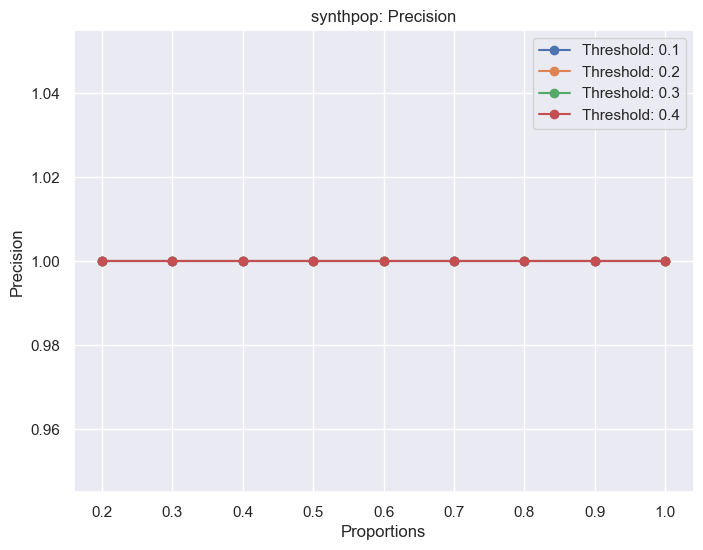

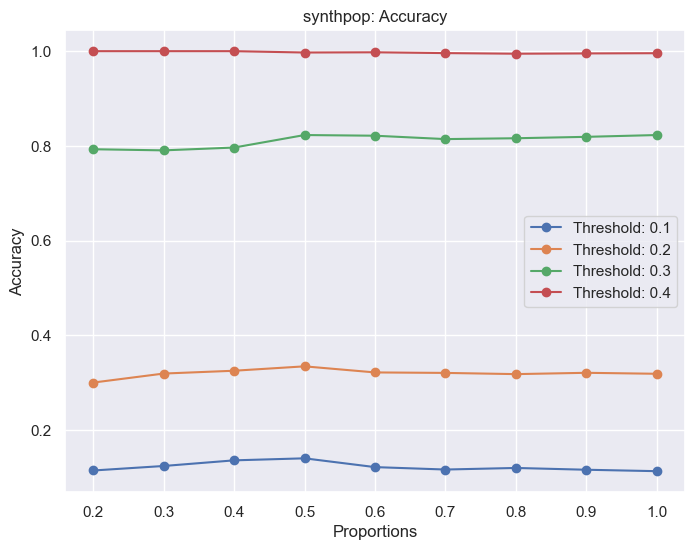

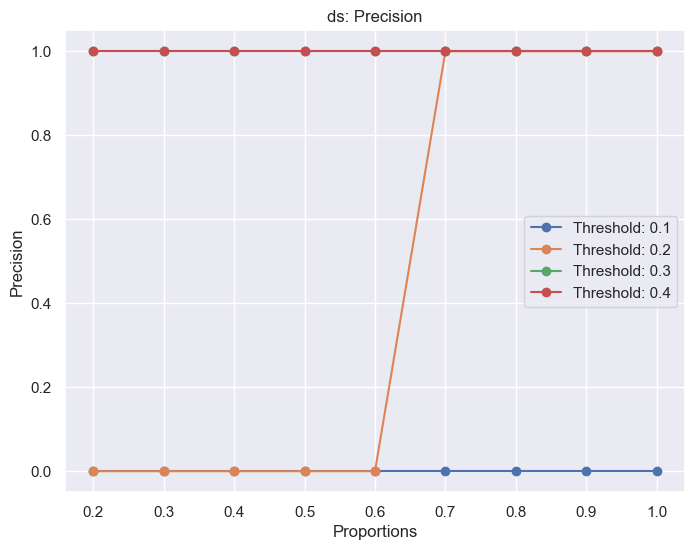

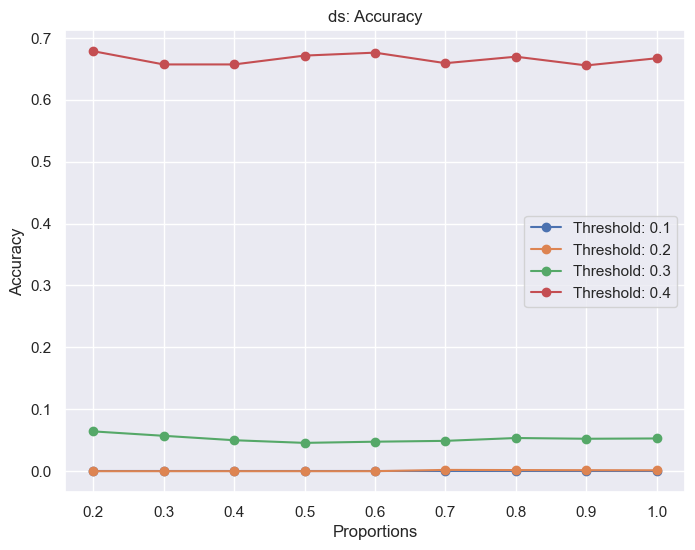

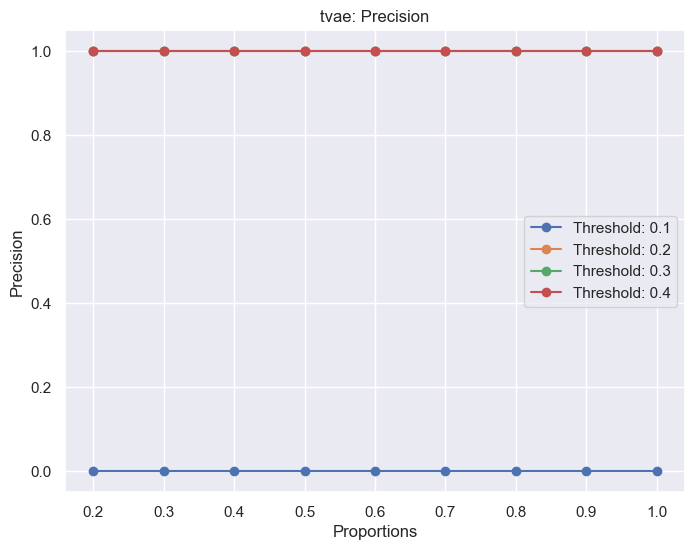

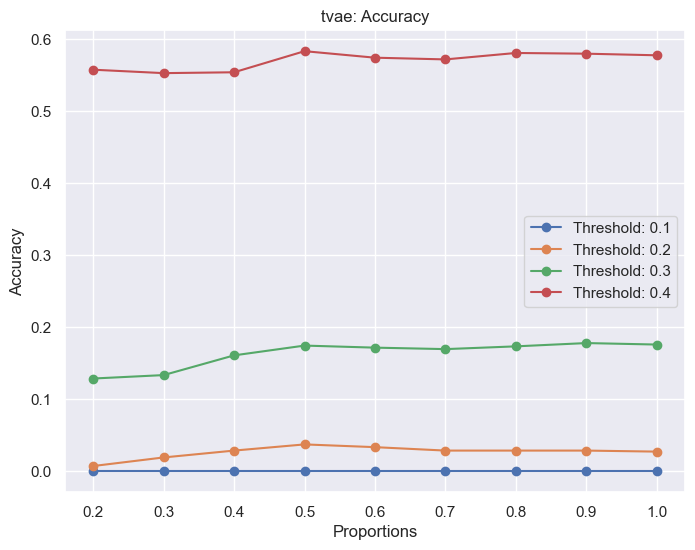

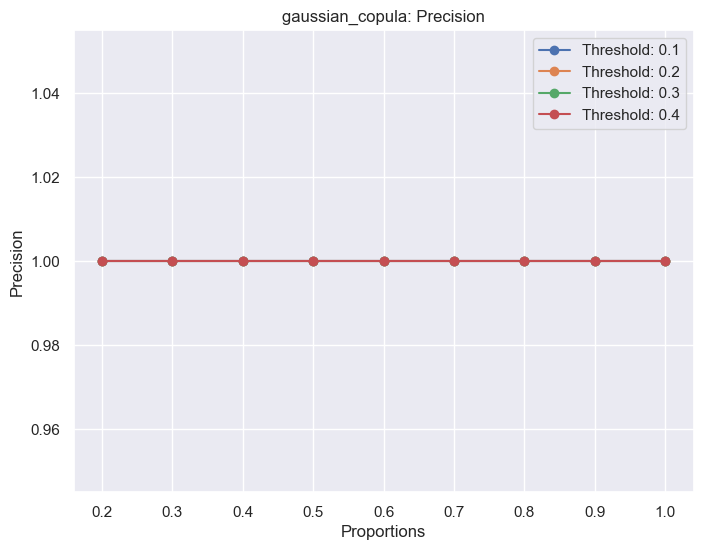

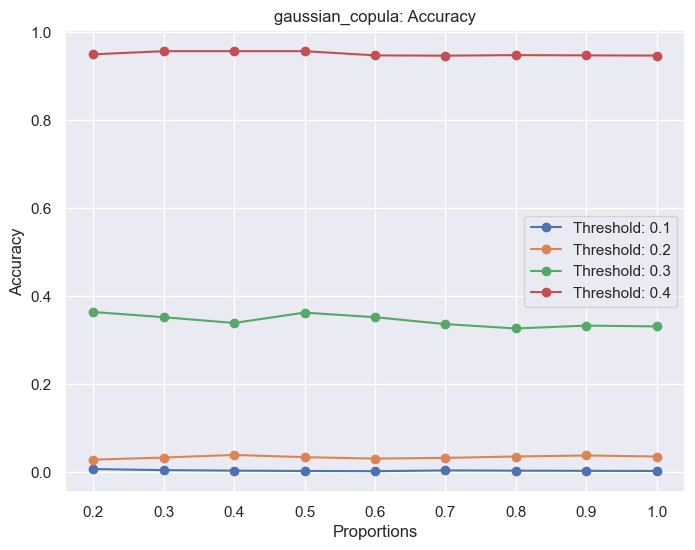

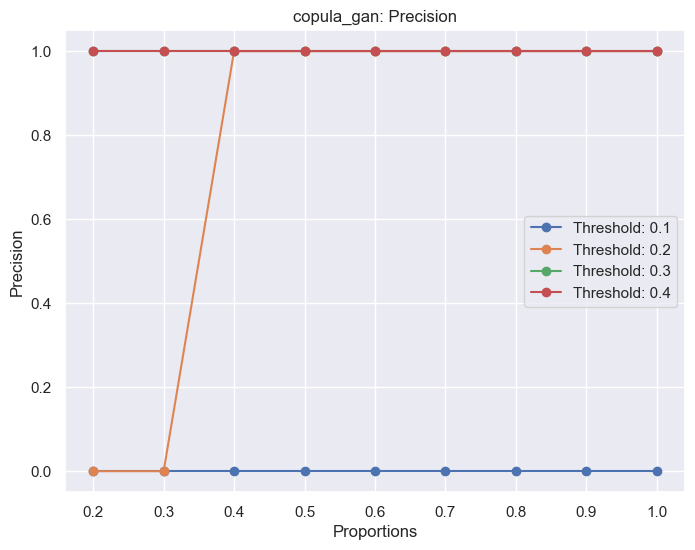

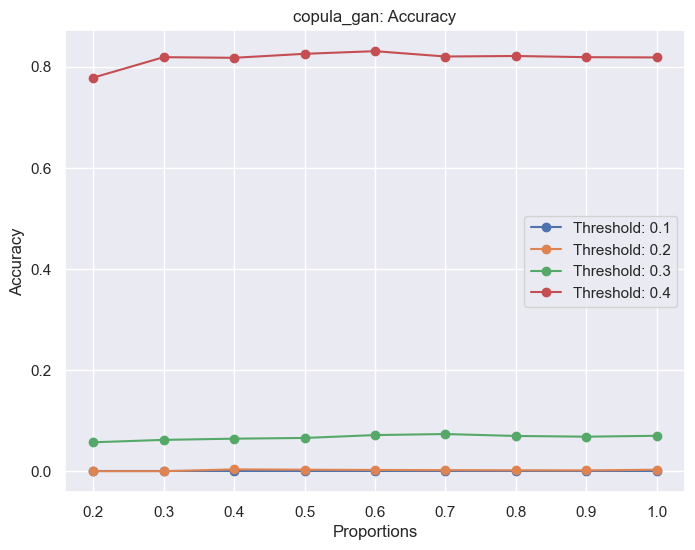

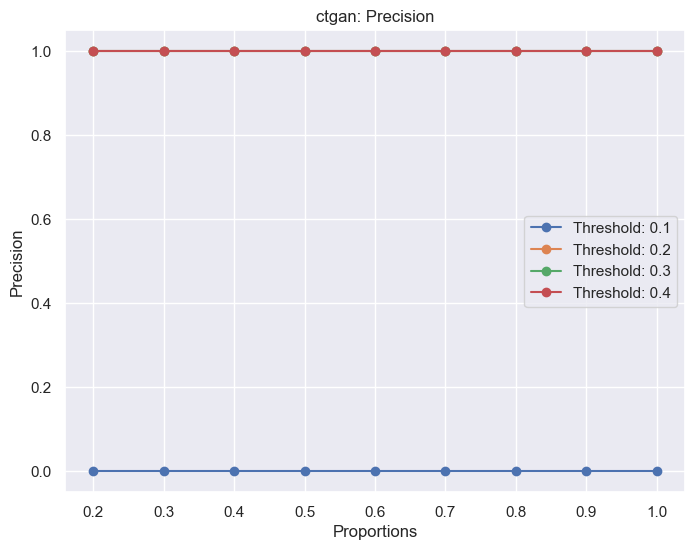

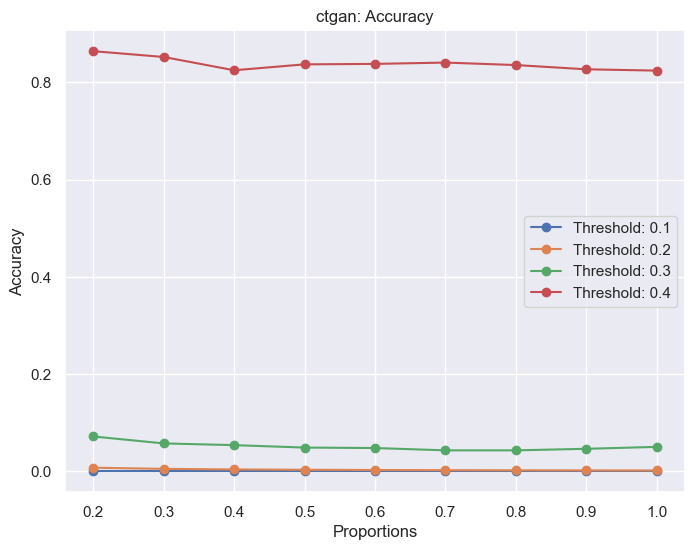

In [19]:
from Data_Evaluation.privacy import mia

mia_results = {}
for i, model in enumerate(models):
    mia_results[model_names[i] + "prec"], mia_results[model_names[i] + "acc"]= mia(train_data, model, model_names[i],save_plts=True)
